In [1]:
from ada_csl_wrc.evaluation import evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from ada_csl_wrc.models import CostSensitiveDecisionTreeClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from ada_csl_wrc.models import ConstrainedCSDecisionTree
from ada_csl_wrc.models import Constrained
from sklearn.model_selection import train_test_split
from ada_csl_wrc.utils import prediction_up_to_constraint
from ada_csl_wrc.utils import prepare_for_cost_cle
from ada_csl_wrc.utils import filter_only_worst_features
from ada_csl_wrc.utils import find_effective_threshold
import json
import pickle
from copy import deepcopy


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


loaded ada_csl_wrc.utils


### Hyperparameters of the experiment


In [2]:
COST_FALSE_NEGATIVE = 10
COST_FALSE_POSITIVE = 1
t = COST_FALSE_POSITIVE/(COST_FALSE_POSITIVE+COST_FALSE_NEGATIVE)
COST_MATRIX = np.array([[0, COST_FALSE_POSITIVE], [COST_FALSE_NEGATIVE, 0]])
FEATURES_RATIO = 1.0

In [3]:
COST_MATRIX

array([[ 0,  1],
       [10,  0]])

### Data-specific code

This part includes some data-specific code. It is not included in the final model. <br>
The X and the y are the dataframes that are used for training and testing.


In [26]:
cs_best_params = json.load(open("./config/cost_sensitive_best_params.json", "r")) #hard-coded in a json file
#dt_best_params = find_best_params(dt_param_grid, X, y) #find it using grid search
dt_best_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}

In [4]:
df = pd.read_csv('./data/feature_dataset.csv')#, index_col='credentialset_id')


In [5]:
df.head()

,credentialset_id,prediction_date,n_updates_30d,mean_time_30d,max_time_30d,min_time_30d,n_updates_60d,mean_time_60d,max_time_60d,min_time_60d,...,max_time_120d,min_time_120d,provider_n_updates,provider_n_updates_weekday,n_updates_weekday,n_successful_crawls,n_unsuccessful_crawls,is_last_crawl_succed,n_days_since_last_crawl,target
0,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-02,0.260870,4.200000,8,2,0.301887,3.0,8,1,...,14,1,0.349653,0.459135,0.730769,3.0,3.0,0.0,1.0,0.0
1,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-03,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,14,1,0.349653,0.000000,0.000000,3.0,4.0,0.0,1.0,0.0
2,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-04,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,14,1,0.349653,0.314904,0.115385,2.0,5.0,0.0,1.0,0.0
3,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-05,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,14,1,0.349653,0.375000,0.576923,2.0,5.0,0.0,1.0,0.0
4,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-06,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,14,1,0.349653,0.472500,0.560000,2.0,5.0,0.0,1.0,0.0


In [6]:
provider_ids = pickle.load(open("data\provider_ids.pickle", "rb"))

In [7]:
df_with_provider = df.join(provider_ids, on='credentialset_id')
df_with_provider.head()

,credentialset_id,prediction_date,n_updates_30d,mean_time_30d,max_time_30d,min_time_30d,n_updates_60d,mean_time_60d,max_time_60d,min_time_60d,...,min_time_120d,provider_n_updates,provider_n_updates_weekday,n_updates_weekday,n_successful_crawls,n_unsuccessful_crawls,is_last_crawl_succed,n_days_since_last_crawl,target,provider_id
0,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-02,0.260870,4.200000,8,2,0.301887,3.0,8,1,...,1,0.349653,0.459135,0.730769,3.0,3.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
1,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-03,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,1,0.349653,0.000000,0.000000,3.0,4.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
2,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-04,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,1,0.349653,0.314904,0.115385,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
3,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-05,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,1,0.349653,0.375000,0.576923,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
4,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-06,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,1,0.349653,0.472500,0.560000,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9


In [8]:
df_with_provider['provider_id'].value_counts()

867c4a38-0d75-46ff-a4c2-f44cb63be2c9    960
a12f6956-9aca-4550-8caa-2e2f9532674c    540
b954c933-d771-4dc0-8f4f-89db56cf7266    180
ddcca177-076a-4389-b357-bc03fa194438    120
50b5a2d8-06d1-4d8d-b8b3-2b945e7c35d6    120
9b9f5ceb-dea2-49db-8476-4530c1b0c92d    120
22f309a8-1746-49a7-bf6c-678729834573    120
856f211d-c66e-4db7-b910-7419900a70e1    120
451e185d-5ad1-469f-8c33-164884140ffc    120
6f8bd649-7125-40a7-818b-4cc67a4863d2     60
02531004-4599-4177-9d7d-00bc85a200c6     60
3c705cbf-e196-40cf-a4fa-f49e5edf4255     60
614de8cc-42e2-4afc-8490-da3c7fe5ba91     60
324ebb81-07ca-4fa2-9235-6f023e806cdd     60
58b25639-e6ba-4ff0-aed1-5ca66c8debb0     60
402b1bde-d71d-4932-a514-95a2334eb586     60
148d76c1-3e78-4581-b909-e4abd3496e12     60
b8c85476-b870-4de4-ade1-fc8804e8b4bc     60
63a50dc0-315c-485a-b497-c8efb89eff3f     60
9638be39-8160-4fa6-8093-1434234885cb     60
dc4abe91-b03f-4dd2-9987-102db5767235     60
75f8d952-be81-4e22-951e-41b291d211f2     60
444b0293-8056-47e0-a3c8-cd7bca49

In [9]:
provider_test_mask = df_with_provider['provider_id'] == '867c4a38-0d75-46ff-a4c2-f44cb63be2c9'
df_train = df.drop(df[provider_test_mask].index)
df_test = df[provider_test_mask]

In [10]:
df_train.shape

(5040, 26)

In [11]:
df_test.shape

(960, 26)

In [12]:
X_train = df_train.drop(labels=['credentialset_id', 'prediction_date', 'target'], axis=1)
X_test =  df_test.drop(labels='target', axis=1)
y_train = df_train['target']
y_test = df_test['target']

In [13]:
X_test.head()

,credentialset_id,prediction_date,n_updates_30d,mean_time_30d,max_time_30d,min_time_30d,n_updates_60d,mean_time_60d,max_time_60d,min_time_60d,...,mean_time_120d,max_time_120d,min_time_120d,provider_n_updates,provider_n_updates_weekday,n_updates_weekday,n_successful_crawls,n_unsuccessful_crawls,is_last_crawl_succed,n_days_since_last_crawl
0,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-02,0.260870,4.200000,8,2,0.301887,3.0,8,1,...,4.208333,14,1,0.349653,0.459135,0.730769,3.0,3.0,0.0,1.0
1,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-03,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,4.208333,14,1,0.349653,0.000000,0.000000,3.0,4.0,0.0,1.0
2,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-04,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,4.208333,14,1,0.349653,0.314904,0.115385,2.0,5.0,0.0,1.0
3,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-05,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,4.208333,14,1,0.349653,0.375000,0.576923,2.0,5.0,0.0,1.0
4,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-06,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,4.208333,14,1,0.349653,0.472500,0.560000,2.0,5.0,0.0,1.0


In [14]:
X_test['credentialset_id'].unique()

array(['0000349e-0a0f-3373-a4f1-05bce8b528b3',
       '00027fee-20d8-4880-8696-db72f085ac7e',
       '00045e0c-868e-4638-8948-85894a84c03c',
       '000565b1-8659-4b4a-b4e1-0cbd08c83935',
       '00057f30-bff5-34e3-ad8b-e68167183af3',
       '000c3181-ed8b-3c02-b3ce-e8009572c153',
       '000c39c2-7861-310c-a38d-7158e7277a09',
       '000cde40-f744-4b03-b100-242a56ad96e6',
       '000d815f-826d-4e3f-bda7-c356e785e314',
       '000f377d-62c9-4f82-9431-4d8366119328',
       '000fce3f-f5ca-32b6-8ac8-7a618132b753',
       '00104acd-78c9-338a-8e1f-3a5c7d046f35',
       '00116a5c-3002-33ea-89ba-1f88983b311e',
       '001497da-7162-4a28-a393-d7c28f00b129',
       '00168874-3190-3989-bd67-021966445bf3',
       '00172767-57f8-4a46-9fb4-0772ba34dc81'], dtype=object)

In [15]:
X_test['prediction_date'].unique()

array(['2023-06-02', '2023-06-03', '2023-06-04', '2023-06-05',
       '2023-06-06', '2023-06-07', '2023-06-08', '2023-06-09',
       '2023-06-10', '2023-06-11', '2023-06-12', '2023-06-13',
       '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-17',
       '2023-06-18', '2023-06-19', '2023-06-20', '2023-06-21',
       '2023-06-22', '2023-06-23', '2023-06-24', '2023-06-25',
       '2023-06-26', '2023-06-27', '2023-06-28', '2023-06-29',
       '2023-06-30', '2023-07-01', '2023-07-02', '2023-07-03',
       '2023-07-04', '2023-07-05', '2023-07-06', '2023-07-07',
       '2023-07-08', '2023-07-09', '2023-07-10', '2023-07-11',
       '2023-07-12', '2023-07-13', '2023-07-14', '2023-07-15',
       '2023-07-16', '2023-07-17', '2023-07-18', '2023-07-19',
       '2023-07-20', '2023-07-21', '2023-07-22', '2023-07-23',
       '2023-07-24', '2023-07-25', '2023-07-26', '2023-07-27',
       '2023-07-28', '2023-07-29', '2023-07-30', '2023-07-31'],
      dtype=object)

In [16]:
X_test_to_pred = X_test[X_test['prediction_date'] == '2023-07-31'].drop(['credentialset_id', 'prediction_date'], axis=1)
X_test_to_pred

,n_updates_30d,mean_time_30d,max_time_30d,min_time_30d,n_updates_60d,mean_time_60d,max_time_60d,min_time_60d,n_updates_90d,mean_time_90d,...,mean_time_120d,max_time_120d,min_time_120d,provider_n_updates,provider_n_updates_weekday,n_updates_weekday,n_successful_crawls,n_unsuccessful_crawls,is_last_crawl_succed,n_days_since_last_crawl
59,0.173913,3.333333,8,1,0.150943,6.285714,11,1,0.204819,5.000000,...,4.120000,11,1,0.349653,0.375,0.576923,1.0,0.0,1.0,3.0
479,0.173913,6.666667,9,4,0.283019,3.714286,9,1,0.216867,4.294118,...,5.100000,14,1,0.349653,0.375,0.576923,2.0,3.0,0.0,1.0
839,0.565217,1.500000,4,1,0.641509,1.484848,4,1,0.650602,1.490566,...,1.611940,4,1,0.349653,0.375,0.576923,1.0,4.0,0.0,1.0
1199,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.012048,0.000000,...,4.200000,7,1,0.349653,0.375,0.576923,0.0,4.0,0.0,1.0
1259,0.652174,1.500000,4,1,0.377358,2.684211,11,1,0.265060,3.095238,...,4.625000,22,1,0.349653,0.375,0.576923,2.0,3.0,0.0,1.0
2939,0.434783,2.222222,6,1,0.471698,2.125000,6,1,0.457831,2.216216,...,2.055556,6,1,0.349653,0.375,0.576923,3.0,2.0,0.0,1.0
2999,0.173913,4.333333,8,1,0.188679,5.333333,14,1,0.168675,5.923077,...,5.722222,16,1,0.349653,0.375,0.576923,2.0,3.0,0.0,2.0
3059,0.608696,1.615385,3,1,0.641509,1.575758,4,1,0.662651,1.518519,...,1.473684,4,1,0.349653,0.375,0.576923,2.0,0.0,1.0,3.0
3179,0.130435,6.500000,10,3,0.207547,4.500000,11,1,0.240964,4.000000,...,3.714286,11,1,0.349653,0.375,0.576923,3.0,2.0,1.0,1.0
3479,0.391304,2.000000,5,1,0.566038,1.724138,5,1,0.602410,1.632653,...,1.594203,5,1,0.349653,0.375,0.576923,2.0,2.0,1.0,1.0


In [22]:
y_test_to_pred = y_test[X_test_to_pred.index]
y_test_to_pred

59      0.0
479     0.0
839     0.0
1199    0.0
1259    1.0
2939    1.0
2999    1.0
3059    1.0
3179    1.0
3479    1.0
3719    1.0
3959    1.0
4259    0.0
4859    1.0
5219    1.0
5279    0.0
Name: target, dtype: float64

In [24]:
# the constraint is precent of positive from all the test, so if we want to examine it regarding the number of actual positive we need to define it as follows
constraint = y_test_to_pred.sum()/len(y_test_to_pred)*0.5
constraint

0.3125

In [25]:
16*constraint

5.0

In [27]:
constrained_model = ConstrainedCSDecisionTree(constraint, **cs_best_params)

In [28]:
cost_matrix = prepare_for_cost_cle(len(X_train), COST_MATRIX)

In [29]:
constrained_model.fit(X_train.to_numpy(), y_train.to_numpy(), 10)

Threshold: 0.49 Effective Threshold: 0.49 Cost False Positive: 8.79 Lower Bound: 7.81 Upper Bound: 9.77
DONE
Threshold: 0.47
Effective threshold: 0.47
Current cfp:  8.30078125
Lower bound:  7.8125
Upper bound:  8.7890625


ConstrainedCSDecisionTree(constraint=0.3125)

In [30]:
y_pred = constrained_model.predict(X_test_to_pred.to_numpy())

In [33]:
evaluate(y_test_to_pred, y_pred, COST_MATRIX)

{'cost': 61,
 'accuracy': 0.5625,
 'precision': 0.8,
 'recall': 0.4,
 'f1': 0.5333333333333333}

In [32]:
confusion_matrix(y_test_to_pred, y_pred)

array([[5, 1],
       [6, 4]], dtype=int64)

In [87]:

#initialize the threshold
threshold = 0.0
effective_threshold = 1.0
lower_bound = 0.0
upper_bound = 1000.0 #Should be a big number, I don't know what is big enough
cfp = 0
cfn = 10
results = {}
cm_dict = {}
i = 0

#High CFP increase the threshold and vice versa
while (effective_threshold > threshold) or (abs(upper_bound - lower_bound) > 1.0):
#for i in range(50):

    print(
        f"Threshold: {threshold:.2f}", 
        f"Effective Threshold: {effective_threshold:.2f}", 
        f"Cost False Positive: {cfp:.2f}", 
        f"Lower Bound: {lower_bound:.2f}",
        f"Upper Bound: {upper_bound:.2f}",
        sep = " ", end="\r", flush=True)
    
    threshold = cfp/(cfp+cfn)
    cost_matrix = np.array([[0, cfp], 
                            [cfn, 0]])
    model_i = CostSensitiveDecisionTreeClassifier() #The base object, we will train it.
    model_i.set_params(**cs_best_params)
    model_i.fit(X_train.to_numpy(), y_train.to_numpy(), cost_mat = prepare_for_cost_cle(len(X_train), cost_matrix)) 
    y_pred_proba_test = model_i.predict_proba(X_test_to_pred.to_numpy())[:, 1]
    effective_threshold = find_effective_threshold(y_pred_proba_test, constraint, threshold) 
    y_pred_test = prediction_up_to_constraint(y_pred_proba_test, constraint)
    results[i] =  evaluate(y_test[X_test_to_pred.index], y_pred_test, COST_MATRIX)
    cm_dict[i] = confusion_matrix(y_test[X_test_to_pred.index], y_pred_test)

    #The binary search, if we overshot, we need to decrease cfp
    if effective_threshold <= threshold: #It means we have found a good cfp, but might not be the best
        upper_bound = cfp
        cfp = (cfp+lower_bound)/2
              
    else: #We undershot, we need to increase cfp
        lower_bound = cfp
        cfp = (cfp+upper_bound)/2
    i+=1
    
best_model_ = deepcopy(model_i) #This one is already trained.
cfp_ = cfp
threshold_ = threshold

print("\nDONE")
print(f"Threshold: {threshold:.2f}")
print(f"Effective threshold: {effective_threshold:.2f}")
print("Current cfp: ", cfp)
print("Lower bound: ", lower_bound)
print("Upper bound: ", upper_bound)

Threshold: 0.74 Effective Threshold: 0.87 Cost False Positive: 28.81 Lower Bound: 28.32 Upper Bound: 29.30
DONE
Threshold: 0.74
Effective threshold: 0.74
Current cfp:  28.564453125
Lower bound:  28.3203125
Upper bound:  28.80859375


In [59]:
#initialize the threshold
threshold = 0.0
effective_threshold = 1.0
lower_bound = 0.0
upper_bound = 1000.0 #Should be a big number, I don't know what is big enough
cfp = 1
cfn = 10
results_old_search = {}
cm_dict_old_search = {}
threshold_dict = {}
#i = 0

#High CFP increase the threshold and vice versa
for i in range(50):

    
    threshold = cfp/(cfp+cfn)
    cost_matrix = np.array([[0, cfp], 
                            [cfn, 0]])
    model_i = CostSensitiveDecisionTreeClassifier() #The base object, we will train it.
    model_i.set_params(**cs_best_params)
    model_i.fit(X_train.to_numpy(), y_train.to_numpy(), cost_mat = prepare_for_cost_cle(len(X_train), cost_matrix)) 
    y_pred_proba_test = model_i.predict_proba(X_test_to_pred.to_numpy())[:, 1]
    effective_threshold = find_effective_threshold(y_pred_proba_test, constraint, threshold) 
    threshold_dict[i] = {'threshold': threshold, 'effective_threshold': effective_threshold}
    y_pred_test = prediction_up_to_constraint(y_pred_proba_test, constraint)
    results_old_search[i] =  evaluate(y_test_to_pred, y_pred_test, COST_MATRIX)
    cm_dict_old_search[i] = confusion_matrix(y_test_to_pred, y_pred_test)
    print(
        f"Threshold: {threshold:.2f}", 
        f"Effective Threshold: {effective_threshold:.2f}", 
        f"Cost False Positive: {cfp:.2f}",
        sep = " ", end="\r", flush=True)
    cfp+=1
    if effective_threshold <= threshold:
        print('break')
    
# best_model_ = deepcopy(model_i) #This one is already trained.
# cfp_ = cfp
# threshold_ = threshold

print("\nDONE")
# print(f"Threshold: {threshold:.2f}")
# print(f"Effective threshold: {effective_threshold:.2f}")
# print("Current cfp: ", cfp)
# print("Lower bound: ", lower_bound)
# print("Upper bound: ", upper_bound)

breakhold: 0.74 Effective Threshold: 0.74 Cost False Positive: 29.00
breakhold: 0.75 Effective Threshold: 0.75 Cost False Positive: 30.00
breakhold: 0.76 Effective Threshold: 0.76 Cost False Positive: 31.00
breakhold: 0.76 Effective Threshold: 0.76 Cost False Positive: 32.00
breakhold: 0.77 Effective Threshold: 0.77 Cost False Positive: 33.00
breakhold: 0.77 Effective Threshold: 0.77 Cost False Positive: 34.00
breakhold: 0.78 Effective Threshold: 0.78 Cost False Positive: 35.00
breakhold: 0.78 Effective Threshold: 0.78 Cost False Positive: 36.00
breakhold: 0.79 Effective Threshold: 0.79 Cost False Positive: 37.00
breakhold: 0.79 Effective Threshold: 0.79 Cost False Positive: 38.00
breakhold: 0.80 Effective Threshold: 0.80 Cost False Positive: 39.00
breakhold: 0.80 Effective Threshold: 0.80 Cost False Positive: 40.00
breakhold: 0.80 Effective Threshold: 0.80 Cost False Positive: 41.00
breakhold: 0.81 Effective Threshold: 0.81 Cost False Positive: 42.00
breakhold: 0.81 Effective Threshol

In [49]:
def plot_search_comparison(results_new, results_old, metric):
    metric_new = [results_new[k][metric] for k in results_new.keys()]
    metric_old = [results_old[k][metric] for k in results_old.keys()]
    plt.plot(range(len(metric_new)), metric_new, label='new search')
    plt.plot(range(len(metric_old)), metric_old, label='old search')
    plt.xlabel('Iteration')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

In [73]:
y_pred_proba_best_model = best_model_.predict_proba(X_test_to_pred.to_numpy())[:, 1] 
y_pred_best_model = prediction_up_to_constraint(y_pred_proba_best_model, constraint)
evaluate(y_test_to_pred, y_pred_best_model, COST_MATRIX)
#confusion_matrix(y_test_to_pred, y_pred_best_model)

{'cost': 72, 'accuracy': 0.4375, 'precision': 0.6, 'recall': 0.3, 'f1': 0.4}

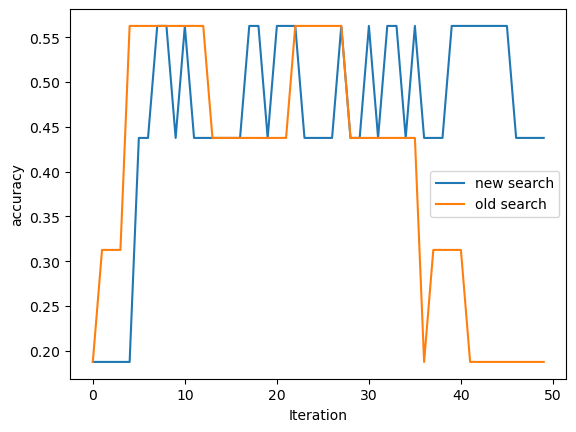

In [80]:
# both method with 50 iterations
plot_search_comparison(results, results_old_search, 'accuracy')

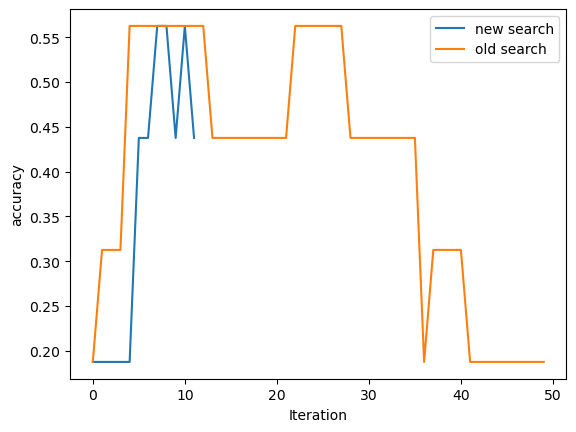

In [88]:
plot_search_comparison(results, results_old_search, 'accuracy')

In [86]:
results

{0: {'cost': 72,
  'accuracy': 0.4375,
  'precision': 0.6,
  'recall': 0.3,
  'f1': 0.4}}

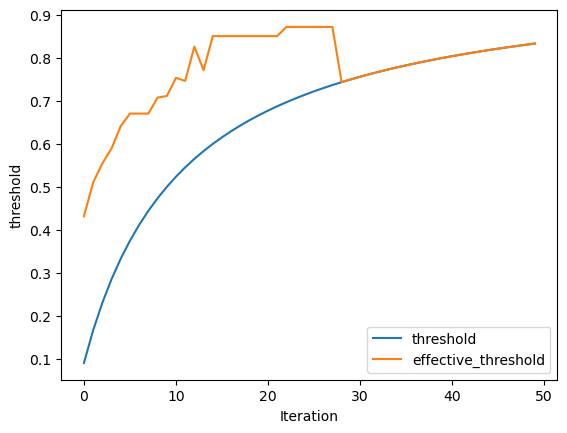

In [82]:
threshold_list = [threshold_dict[k]['threshold'] for k in threshold_dict.keys()]
effective_threshold_list = [threshold_dict[k]['effective_threshold'] for k in threshold_dict.keys()]
plt.plot(range(len(threshold_list)), threshold_list, label='threshold')
plt.plot(range(len(effective_threshold_list)), effective_threshold_list, label='effective_threshold')
plt.xlabel('Iteration')
plt.ylabel('threshold')
plt.legend()
plt.show()

In [75]:
accuracy_old = [results_old_search[k]['accuracy'] for k in results_old_search.keys()]

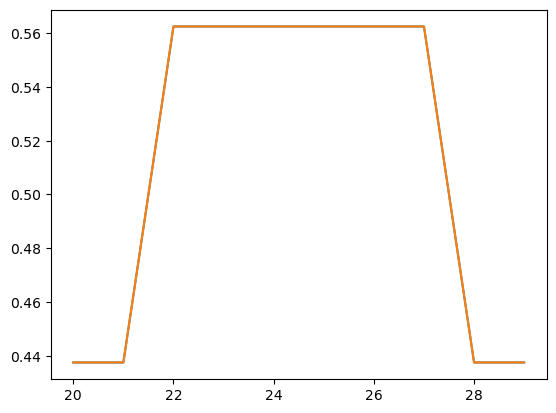

In [77]:
plt.plot(range(20,30), accuracy_old[20:30])
plt.show()

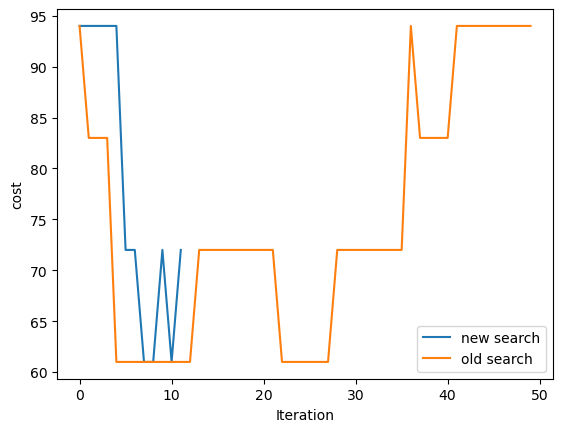

In [61]:
plot_search_comparison(results, results_old_search, 'cost')

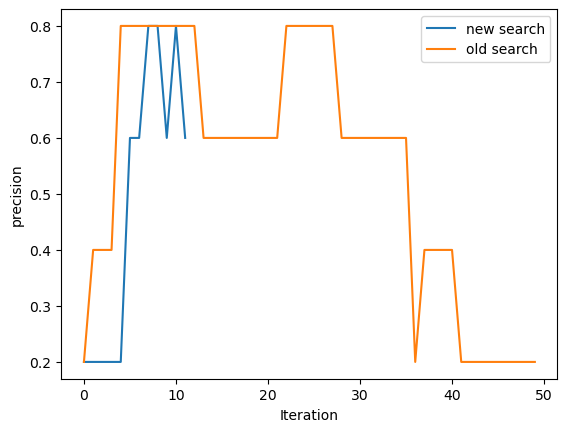

In [62]:
plot_search_comparison(results, results_old_search, 'precision')

In [10]:
X = df.drop(labels = 'target', axis=1)
y = df['target']

In [11]:
def find_best_params(param_grid, X, y):
    # Used for this dataset specifically, to find the best parameters for the decision tree
    # Let's think about more general way to do so.
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, n_jobs=-1, scoring='f1', verbose=3)
    grid.fit(X, y)
    return grid.best_params_

In [12]:
dt_param_grid = {
    "max_depth": [3, 5, 10, 15],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [10, 15, 20, 30]
}

cs_best_params = json.load(open("./config/cost_sensitive_best_params.json", "r")) #hard-coded in a json file
#dt_best_params = find_best_params(dt_param_grid, X, y) #find it using grid search
dt_best_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}

## Starting the experiment


In [18]:
y

credentialset_id
0000349e-0a0f-3373-a4f1-05bce8b528b3    0.0
0000349e-0a0f-3373-a4f1-05bce8b528b3    0.0
0000349e-0a0f-3373-a4f1-05bce8b528b3    0.0
0000349e-0a0f-3373-a4f1-05bce8b528b3    0.0
0000349e-0a0f-3373-a4f1-05bce8b528b3    0.0
                                       ... 
0018df90-340f-4926-ba6c-ff3b0d3fe325    1.0
0018df90-340f-4926-ba6c-ff3b0d3fe325    0.0
0018df90-340f-4926-ba6c-ff3b0d3fe325    0.0
0018df90-340f-4926-ba6c-ff3b0d3fe325    0.0
0018df90-340f-4926-ba6c-ff3b0d3fe325    1.0
Name: target, Length: 6000, dtype: float64

In [13]:
real_positive_ratio = y.mean()


In [14]:
constraints_range = np.array([0.25, 0.75]) * real_positive_ratio
constraints = #np.linspace(*constraints_range, 50)

### Decision Tree
With best params from the grid search, applying on various of constraints

In [15]:
from tqdm import tqdm


In [17]:
def run_constrained_experiment(constrained_model:Constrained, 
                               X, 
                               y, 
                               cost_matrix, 
                               constraint, 
                               random_state=42, 
                               n_splits=3):

    fit_params = {}
    out = {}
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for (fold, (train_index, test_index)) in enumerate(kf.split(X, y)):
        #The ordinary Kfold, but with the constraint
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if isinstance(constrained_model.model, CostSensitiveDecisionTreeClassifier):
            #The Cost Sensitive Decision Tree also needs the cost matrix as a fit parameter
            fit_params['cost_mat'] = prepare_for_cost_cle(len(X_train), cost_matrix)

        constrained_model.fit(X_train, y_train, **fit_params) #Fitting the model

        #The constraint is a float between 0 and 1
        y_pred = constrained_model.predict_constrained(X_test, constraint=constraint)
        
        out[fold] = evaluate(y_test, y_pred, cost_matrix)
    

    return pd.DataFrame(out).T.mean(axis=0).to_dict() #Returning the mean of the metrics



In [ ]:
results = {}
for random_state in tqdm(range(10)):
    for constraint in tqdm(constraints):
        partial_results = run_constrained_experiment(Constrained(DecisionTreeClassifier(**dt_best_params)),
                                    X.values,
                                    y.values,
                                    COST_MATRIX,
                                    constraint=constraint, 
                                    random_state=random_state)
        results[(random_state, constraint)] = partial_results
results = pd.DataFrame(results).T